# Predicting Home Prices With Regression
__Greg Maggard__ <br>
July 22, 2022

## <span style = 'color:blue'>General Overview:</span>
This project aims to use regression models to predict home values from the Zillow dataset containing listings from 2017.

<span style = 'color:blue'>============================================================================================</span>

### Main Goals:
- Use regression machine learning models to make predictions regarding housing prices. 
- Identify key features that can be used to create an effective predictive model.
- Use findings to make recommendations and establish a foundation for future work to improve model's performance. 

<span style = 'color:blue'>============================================================================================</span>

### Executive Summary:
- This project aims to improve upon an existing model to predict home prices for Zillow listings from 2017.
- Data was acquired by querying 2017 home data from the Zillow database. 
- Exploration was done to test some hypotheses about relationships between features. 
- Multiple regression models were run, ultimately finding Linear Regression to be the most effect, reducing the model's error by ~19.44%.
- I recommend deploying this model over the original for the time being, given that there is a 20% increase in model performance.
- Given more time, I'd like to continue to refine the model with current features, while also trying to add more home features and data into the dataset.

## <span style = 'color:blue'>Importing Relevant Tools:</span>

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

α = .05

from env import get_db_url
import wrangle as wr
import explore as ex

from stats_toolkit import significance_test
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

## <span style = 'color:blue'>Acquiring Data:</span>

### Querying database for *single family homes* that have transaction dates *during the year of 2017:*

```SQL
SELECT
        bathroomcnt AS bathrooms,
        bedroomcnt AS bedrooms,
        taxvaluedollarcnt AS value,
        calculatedfinishedsquarefeet AS square_feet, 
        yearbuilt AS year_built,
        fips, 
        latitude,
        longitude,
        lotsizesquarefeet AS lot_size
        FROM properties_2017 
        LEFT JOIN predictions_2017 USING (parcelid) 
        LEFT JOIN propertylandusetype USING (propertylandusetypeid)
        WHERE propertylandusedesc IN ('Single Family Residential',
        'Inferred Single Family Residential') 
        AND YEAR(transactiondate) = 2017;
``` 
            
<span style = 'color:blue'>============================================================================================</span>

### Data Dictionary: 

| Column/Feature | Description |
|--- | --- |
| __bathrooom__ | The number of bathrooms in the home. |
| __bedrooms__ | The number of bedrooms in the home. |
| __value__ | The tax-assessed value of the home. <br> __Not__ the home's ultimate sale price. |
| __square_feet__ | The home's square footage. |
| __year_built__ | The year the home was built. |
| __fips__ | "Federal Information Process System" code, used to <br> identify zip codes in the U.S. |
| __latitude__ | The latitude of the home. |
| __longitude__ | The longitude of the home. |
| __lot_size__ | The square footage of the lot on which <br> the home is built. |

### Using Pandas to Save Query Output to DataFrame:
__52,441 rows are returned, with the above 9 columns:__

In [2]:
query_df = wr.get_zillow_data()
query_df.head(2)

,bathrooms,bedrooms,value,square_feet,year_built,fips,latitude,longitude,lot_size
0,3.5,4.0,1023282.0,3100.0,1998.0,6059.0,33634931.0,-117869207.0,4506.0
1,1.0,2.0,464000.0,1465.0,1967.0,6111.0,34449266.0,-119281531.0,12647.0


<span style = 'color:blue'>============================================================================================</span>

## <span style = 'color:blue'> Wrangling Data: </span>

### - General Data Format Cleaning:
- Converting moving decimal left 6 places on latitude and longitude.

### - Assigning county names to each home, based on the fips code one the record:  
- 60370: Los Angeles County
- 60490: Orange County
- 61110: Ventura County

### - Homes Dropped:
- Having 0 bedrooms
- Having 0 bathrooms
- Having less than 120 square feet
    - These homes to not meet the CA minimum to classify as a residence.
- Having more than 10,000 square feet
    - These homes make up a small portion of the set and could skew the model.
- Home value over 1.6 million dollars
    - These homes make up a small portion of the set and could skew the model.
- Having more than 100,000 square footage of lot size.
    - These homes make up a small portion of the set and could skew the model.
- Home records containing null values in any column.
    
### - Columns Created:
- Column displaying the ratios of bedrooms to bathrooms.

### Notes on Wrangling:
- All of these cleaning steps are carried out in the wrangle script, and leave 94.3\% of the data remaining. 
- I feel comfortable with the omission of this data, as I want to ensure that I'm not excluding too large a chunk of my total set, but do want to be sure that I'm focusing my model on homes that comprise the bulk of Zillow's business.

In [3]:
df = wr.wrangle_zillow()
df.head(1)

,bathrooms,bedrooms,value,square_feet,year_built,latitude,longitude,lot_size,county,bath_bed_ratio
0,3.5,4,1023282.0,3100.0,1998,33.634931,-117.869207,4506.0,Orange County,0.875


### Splitting the Data Before Exploration:
Using a scripted function to split the cleaned data into train, validate, and test sets.

In [4]:
train, validate, test = wr.split_zillow_data(df)

In [5]:
train.head(1)

,bathrooms,bedrooms,value,square_feet,year_built,latitude,longitude,lot_size,county,bath_bed_ratio
37492,2.0,3,468048.0,3233.0,1950,33.96735,-117.974418,80171.0,Los Angeles County,0.666667



<span style = 'color:blue'>============================================================================================</span>

## <span style = 'color:blue'> Exploration: </span>

### Key Questions Answered:
- Is there a significant relationship between square footage and home value?
    - __Statistical Finding: There is sufficient evidence to reject the null and assert that there is a significant relationship between square footage and the assessed value.__
- Is there a significant relationship between lot_size and home value?
    - __Findings: There is sufficient evidence to reject the null and assert that there is a significant relationship between lot size and the assessed value.__
- Is there a relationship between the county in which a home is built and its value?
    - __Statistical Finding: There is sufficient evidence to reject the null and assert that there is a meaningful relationship between home values and county.__
- Is there a relationship between the year a home is built and the square footage of a home?
    - __Statistical Finding: There is sufficient evidence to reject the null and assert that there is a meaningful relationship between home values and county.__

<span style = 'color:blue'>============================================================================================</span>

### Visualizing Distribution of Homes by Square Footage:

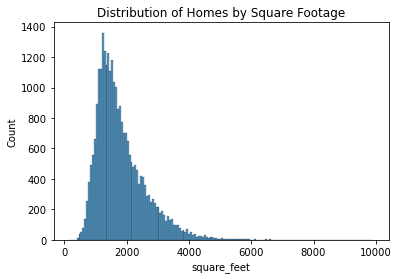

In [6]:
sns.histplot(data = train, x = train.square_feet).set(title = 'Distribution of Homes by Square Footage');

#### Is there a relationship between square footage and value?

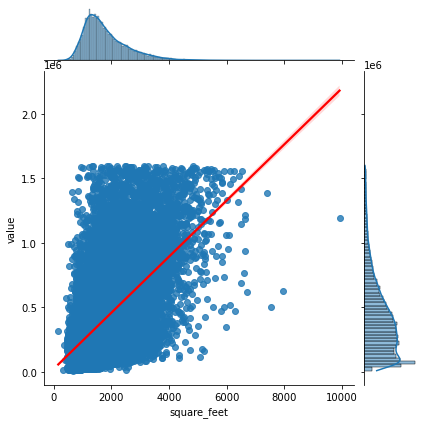

In [7]:
sns.jointplot(x = "square_feet", y = "value", data = train, kind = 'reg',
                  joint_kws = {'line_kws':{'color':'red'}});

#### Statistical Test:
- Null Hypothesis: There is no significant relationship between the home's square footage and the assessed value.
- Alternative Hypothesis: There is a significant relationship between the home's square footage and the assessed value.
- __Findings: There is sufficient evidence to reject the null and assert that there is a significant relationship between square footage and the assessed value.__ 
    - It appears that as time as square footage increases, value tends to increase as well.

In [8]:
#Running a Pearson's R test to check the correlation between square footage and a home's value:
corr, p = stats.pearsonr(train.square_feet, train.value)
#Running a significance test to determine whether we can reject the null:
significance_test(p)
print(f'The correlation coefficient for square footage and value is {round(corr, 2)}.')

Sufficient evidence -> Reject the null hypothesis.
The correlation coefficient for square footage and value is 0.55.


### Visualizing Distribution of Homes by Lot Size:

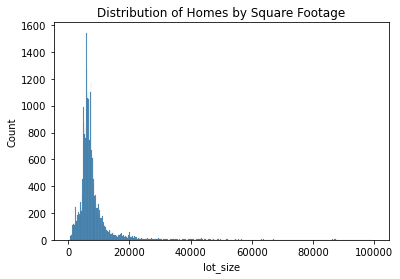

In [9]:
sns.histplot(data = train, x = train.lot_size).set(title = 'Distribution of Homes by Square Footage');

#### Is there a relationship between home lot size and value?

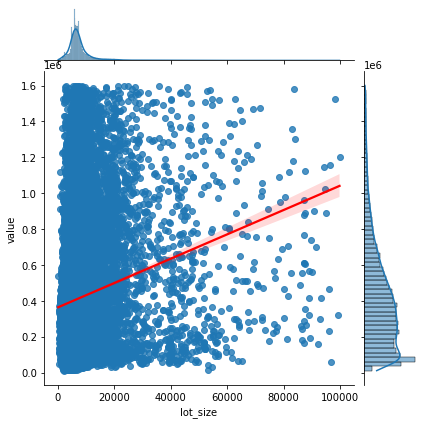

In [10]:
sns.jointplot(data = train, x = "lot_size", y = "value", kind = 'reg',
                  joint_kws = {'line_kws':{'color':'red'}});

#### Statistical Test:
- Null Hypothesis: There is no significant relationship between the home's lot size and the assessed value.
- Alternative Hypothesis: There is a significant relationship between the home's lot size and the assessed value.
- __Findings: There is sufficient evidence to reject the null and assert that there is a significant relationship between lot size and the assessed value.__ 
    - It appears that as time as lot size increases, value tends to increase as well.

In [11]:
#Running a Pearson's R test to check the correlation between lot size and the value of a home:
corr, p = stats.pearsonr(train.lot_size, train.value)
#Running a significance test to determine whether we can reject the null:
significance_test(p)
print(f'The correlation coefficient for lot size and value is {round(corr, 2)}.')

Sufficient evidence -> Reject the null hypothesis.
The correlation coefficient for lot size and value is 0.16.


### Visualizing Home Values by County:

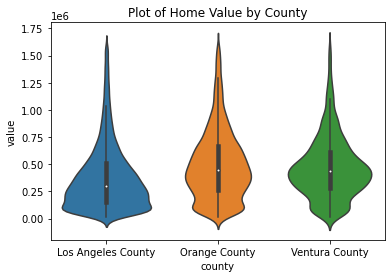

In [12]:
sns.violinplot(data = train, x = train.county, y = train.value ).set(title = 'Plot of Home Value by County');

#### Stats: Does County of Residence Have a Meaningful Impact on Value?
- Null Hypothesis: There is no relationship between county and home value.
- Alternative Hypothesis: There is a significant relationship between county and home value.
- __Findings: There is sufficient evidence to reject the null and assert that there is a meaningful relationship between county and home values.__

In [13]:
#Creating Separate DataFrames by County:
la_values = train[train.county == 'Los Angeles County'].value
orange_values = train[train.county == 'Orange County'].value
ventura_values = train[train.county == 'Ventura County'].value

#Running a one-way ANOVA (there is a single independent variable - 'county'):
f, p = stats.f_oneway(la_values, orange_values, ventura_values)

#Printing whether the p-value is less than alpha:
significance_test(p)

Sufficient evidence -> Reject the null hypothesis.


### Distribution of Homes by Year Built:

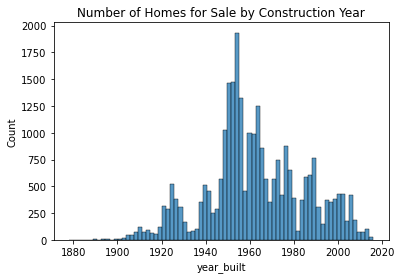

In [14]:
sns.histplot(data = train, x = train.year_built).set(title = 'Number of Homes for Sale by Construction Year');

### The Relationship Between the Year a Home Was Built and the Square Footage:

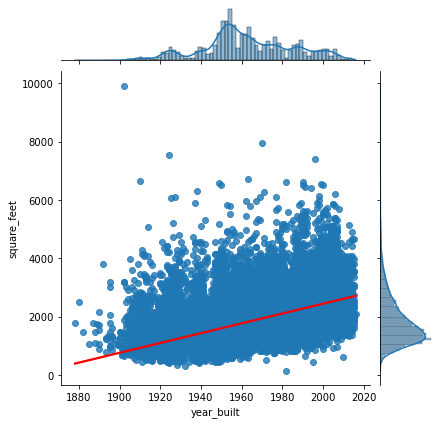

In [15]:
sns.jointplot(x = "year_built", y = "square_feet", data = train, kind = 'reg',
                  joint_kws = {'line_kws':{'color':'red'}});

#### Stats: Is there a relationship between the year a home was built and the square footage?
- Null Hypothesis: There is no relationship between the year a home was built and the square footage.
- Alternative Hypothesis: There is a significant relationship between the year a home was built and the square footage.
- __Findings: There is sufficient evidence to reject the null and assert that there is a meaningful relationship between construction year and square footage.__ 
    - It appears that as time has progressed, homes are being built larger.

In [16]:
#Running a Pearson's R test to check the correlation between year built and square footage in a home:
corr, p = stats.pearsonr(train.square_feet, train.year_built)
#Running a significance test to determine whether we can reject the null:
significance_test(p)
print(f'The correlation coefficient for build year and square footage is {round(corr, 2)}.')

Sufficient evidence -> Reject the null hypothesis.
The correlation coefficient for build year and square footage is 0.48.


### Key Explore Takeaways:

The following findings mean their variables will be used in the modeling:
- There is a significant relationship between __square footage__ and value.
- There is a significant relationship between __lot size__ and value.
- There is a significant relationship between the __county__ a home is in and its value.
- There is a significant relationship between the __year__ a home was built and its value.

Other factors, such as the value of the land, the value of the structure, and the tax amount were left out, as including them would lead to information bleed and compromise the model's fit.

<span style = 'color:blue'>============================================================================================</span>

# <span style = 'color:blue'>Modeling:</span>

## Prepping Data for Modeling:

### Splitting Train, Validate, Test Into 'X' and 'y' Sets For Modeling: 

In [17]:
#Splitting Train Set:
X_train = train.drop(columns = ['value'])
y_train = train.drop(columns = X_train)

#Splitting Validate Set:
X_validate = validate.drop(columns = ['value'])
y_validate = validate.drop(columns = X_validate)

#Splitting Test Set:
X_test = test.drop(columns = ['value'])
y_test = test.drop(columns = X_test)

### Encoding County Data for Modeling:

In [18]:
X_train = wr.encode_zillow_data(X_train)
X_validate = wr.encode_zillow_data(X_validate)
X_test = wr.encode_zillow_data(X_test)

### Scaling Data:

In [19]:
X_train_scaled, X_validate_scaled, X_test_scaled = wr.scale_zillow_data(X_train, X_validate, X_test)

In [20]:
X_train_scaled.head()

,bathrooms,bedrooms,square_feet,year_built,latitude,longitude,lot_size,bath_bed_ratio,county_Orange County,county_Ventura County
37492,0.111111,0.222222,0.315482,0.521739,33.967350,-117.974418,0.803238,0.063927,0,0
17287,0.111111,0.222222,0.156973,0.565217,34.186815,-118.617523,0.154126,0.063927,0,0
37793,0.111111,0.333333,0.170694,0.579710,33.760669,-118.313263,0.077385,0.041096,0,0
27628,0.166667,0.222222,0.194757,0.782609,33.710195,-117.775035,0.042496,0.086758,1,0
36486,0.111111,0.333333,0.174381,0.789855,34.319200,-118.476752,0.173600,0.041096,0,0


<span style = 'color:blue'>============================================================================================</span>

## Baseline Model:
- The mean baseline proved to have the lowest error, so it was selected as baseline for evaluating the final model.
- It's important to note here that there is no "machine learning" happening with this model; all it is doing is finding the mean assessed home value and saving that to a new column in the DataFrame.

In [21]:
#Adding mean baseline value to y_train:
y_train['baseline_mean'] = y_train.value.mean()
#Adding mean baseline value to y_validate:
y_validate['baseline_mean'] = y_validate.value.mean()

### Calculating RMSE (Error) for Baseline Model:

In [22]:
# Creating an empty list for baseline results:
results = []

# Creating a dictionary of baseline mean values:
baseline_mean = {
    'model':'baseline_mean',
    'RMSE_train': mean_squared_error(y_train['value'], y_train['baseline_mean']) ** 0.5,
    'RMSE_validate': mean_squared_error(y_validate['value'], y_validate['baseline_mean'])** 0.5
}
#Appending baseline mean to results list:
results.append(baseline_mean)

#Creating a DataFrame from the list of result dictionaries:
results = pd.DataFrame(results)
results

,model,RMSE_train,RMSE_validate
0,baseline_mean,311363.354731,311821.692922


<span style = 'color:blue'>============================================================================================</span>

## LinearRegression (OLS) Model:

In [23]:
#Creating an empty list for the error calculations:
error = []

# Creating the Model Object:
lm = LinearRegression(normalize=True)

# Fitting the model to the value in the training set:
lm.fit(X_train_scaled, y_train.value)

# Using OLS to make predictions on training set:
y_train['OLS_pred'] = lm.predict(X_train_scaled)

# Calculating the RMSE for train:
rmse_train = mean_squared_error(y_train.value, y_train.OLS_pred)**(0.5)

# Using OLS to make predictions on validate set:
y_validate['OLS_pred'] = lm.predict(X_validate_scaled)

# Calculating the RMSE for validate:
rmse_validate = mean_squared_error(y_validate.value, y_validate.OLS_pred)**(0.5)

#Creating a dictionary of ols_regression stats:
ols_regression = {
    'model':'ols_regression',
    'RMSE_train': mean_squared_error(y_train['value'], y_train['OLS_pred'])**(0.5),
    'RMSE_validate': mean_squared_error(y_validate['value'], y_validate['OLS_pred'])**(0.5)
}

#Adding the ols_regression stats to the empty list:
error.append(ols_regression)
#Converting the list to a DataFrame:
error = pd.DataFrame(error)

#Concatenating the RMSE DataFrames, ignoring index so it auto-updates in the final DataFrame:
results = pd.concat([results, error], ignore_index = True)
results

,model,RMSE_train,RMSE_validate
0,baseline_mean,311363.354731,311821.692922
1,ols_regression,247685.435791,250445.090236


<span style = 'color:blue'>============================================================================================</span>

## Testing Model Performance on the Test Set:

### Generating OLS Regression Prediction for Test and Creating RMSE_test Column:

In [24]:
#Creating an empty list for the error calculations:
error = []

# Creating the Model Object:
lm = LinearRegression(normalize=True)

# Fitting the model to the values in the training set:
lm.fit(X_train_scaled, y_train.value)

# Using OLS to make predictions on training set:
y_train['OLS_pred'] = lm.predict(X_train_scaled)

# Calculating the RMSE for train:
rmse_train = mean_squared_error(y_train.value, y_train.OLS_pred)**(0.5)

# Using OLS to make predictions on test set:
y_test['OLS_pred'] = lm.predict(X_test_scaled)

# Calculating the RMSE for test:
rmse_validate = mean_squared_error(y_test.value, y_test.OLS_pred)**(0.5)

#Creating a dictionary of ols_regression stats:
ols_regression = {
    'model':'ols_regression',
    'RMSE_train': mean_squared_error(y_train['value'], y_train['OLS_pred'])**(0.5),
    'RMSE_test': mean_squared_error(y_test['value'], y_test['OLS_pred'])**(0.5)
}

#Adding the ols_regression stats to the empty list:
error.append(ols_regression)
#Converting the list to a DataFrame:
error = pd.DataFrame(error)

#Concatenating the RMSE DataFrames, ignoring index so it auto-updates in the final DataFrame:
results = pd.concat([results, error], ignore_index = True)

### Generating Baseline Model Prediction for Test Now That RMSE_test Column Exists:

In [25]:
results['RMSE_test'][0] = mean_squared_error(y_validate['value'], y_validate['baseline_mean'])** 0.5
results

,model,RMSE_train,RMSE_validate,RMSE_test
0,baseline_mean,311363.354731,311821.692922,311821.692922
1,ols_regression,247685.435791,250445.090236,NaN
2,ols_regression,247685.435791,NaN,250050.139269


### Calculating the Performance Difference Between the Regression and Baseline:

In [26]:
ols_test_performance = (results.RMSE_test[0] - results.RMSE_test[2]) / results.RMSE_test[0]
print(f"The model beats the baseline by {round((ols_test_performance * 100),2)}%.")

The model beats the baseline by 19.81%.


## Modeling Takeaways:

- The OLS Regression model beats the baseline by ~19.81% on the test set.

<span style = 'color:blue'>============================================================================================</span>

# <span style = 'color:blue'> Conclusion: </span>

## Key Findings:
- Home square footage, lot size, county, and build year all proved to be significant drivers of home value.
- The OLS Linear Regression model, with the features provided, was able to improve upon the baseline model by ~19.81%. I would expect that this will be the case on further out-of-sample data.

## Recommendations:
- I recommend deploying this linear regression model for now, as an improvement of nearly %20 over the current model means there is substantial financial benefit on the line.
- I'd also recommend perhaps doing more qualitative research to understand what factors customers look for in estimating a home's value.

## Next Steps:
- With the luxury of more time, I would like to further explore the variables in the dataset and see if I could find a better combination to refine the model.
- It would likely be worthwhile to look into acquiring more data on the homes to see if there are other factors that could be drivers of home value. 
    - There are factors like how recently a home has been renovated, proximity to quality schools or greenspaces, or myriad other aspects that could be considered.
    
<span style = 'color:blue'>============================================================================================</span>